## Initial Problem Setup

Let's imagine a person throwing darts at a circular target. Unfortunately, due to lack of skill, the dart thrower isn't able to accurately aim, so the probability of hitting each part of the target is exactly the same (uniform probability distribution). 

The circular target has a bullseye painted in the center, and it will look something like this:

[image in blog post]

where the red circle is the bullseye, the blue circle is the target, and the black square is the area outside the target. Assume that the black square just barely encloses the blue target. Although in real life the dart thrower might in fact miss badly enough that they throw the dart outside the black square, let's assume that this is impossible, for now.

Darts are scored in the following way: 2 points if the bullseye is hit, 1 point if the circular target itself is hit (but not the bullseye), and 0 points if the circular target is not hit at all.

Given these parameters, what's the average score per dart?

In the following sections, we will investigate three potential solutions to this problem:

1. Geometrical
2. Image-Based
3. Monte Carlo

Each time, the parameters of the problem will be adjusted to add complexity.

## Situation 1: Geometrical

Using geometry to solve this problem is likely what most people think of first, since we've all probably encountered a similar problem for a class or standardized test. According to established geometrical formulas, we know the area of the bullseye and target (pi times their radius squared), and we know the area of the black square (two times the radius of the target squared). Also, we work under the assumption that the dart is thrown randomly, which means that both the x and y axes can be treated as a uniform probability distribution. For example, it's equally likely to be thrown in the upper left corner as the center, assuming the areas are the same.

Given these assumptions, the probability of hitting the bullseye is just the area of the bullseye divided by the total area, where r_b is the radius of the bullseye and r_t is the radius of the target:

$p_{b} = \frac{BullseyeArea}{TotalArea} = \frac{\pi r_{b}^{2}}{(2r_{t})^{2}} = \frac{\pi r_{b}^{2}}{4r_{t}^{2}}$

The probability of hitting the target (but not the bullseye) is:

$p_{t} = \frac{TargetArea}{TotalArea} - p_{b} = \frac{\pi r_{t}^{2}}{(2r_{t})^{2}} - \frac{\pi r_{b}^{2}}{(2r_{t})^{2}} = \frac{\pi }{4} - \frac{\pi r_{b}^{2}}{4r_{t}^{2}}$

In the equation above, we must subtract out the area of the bullseye because we want to find the probability that the target is hit but the bullseye is **not** hit.

Given that the score for not hitting the target is zero, we won't need to worry about it.

Let's put this all together. If we multiply the probability to hit each area by the score we receive when we hit it, we'll get the expected score per dart throw. In equation form:

$e_{d} = 0p_{n} + 1p_{t} + 2p_{b} = 0 + \frac{\pi }{4} - \frac{\pi r_{b}^{2}}{4r_{t}^{2}} + \frac{2 \pi r_{b}^{2}}{4r_{t}^{2}} = \frac{\pi }{4} + \frac{\pi r_{b}^{2}}{4r_{t}^{2}}$

For the case where the radius of the target is 1 and the radius of the bullseye is 0.1, we get an expected score of:

$e_{d}(1, 0.1) = \frac{\pi }{4} + \frac{0.01 \pi}{4} \approx 0.793$

Given that we have a chance to miss the target entirely, and the bullseye is relatively small compared to the target, this result makes sense.

## Situation 2: Image-Based

Now, what if the shapes weren't drawn perfectly? Imagine that the target wasn't machined but was instead painted on a piece of paper. In this case, the bullseye and target will no longer be necessarily perfect circles, and the above approach would not be as simple. One potential approach is to take a picture of the target, and count the number of pixels of each color.

Let's take the image I drew above as an example. The Python library "pillow" can be used to parse the image into a numpy array:

In [1]:
from PIL import Image
import numpy as np

im = Image.open("TargetMonteCarlo.bmp")
# Convert the image into an array of [R,G,B] per pixel
data = np.array(im.getdata(), np.uint8).reshape(im.size[1], im.size[0], 3)
# For example, the upper left pixel is black ([0,0,0]):
print("Upper left pixel: {}".format(data[0][0]))
# The upper center pixel is blue ([0, 162, 232]):
print("Upper middel pixel: {}".format(data[0][99]))
# And the ~middle pixel is red ([237, 28, 36]):
print("Middle pixel: {}".format(data[99][99]))

Upper left pixel: [0 0 0]
Upper middel pixel: [  0 162 232]
Middle pixel: [237  28  36]


We now have an array of pixels in the [Red, Green, Blue] space. The color codes for the image are:

* Black = [0,0,0]
* Blue = [0,162,232]
* Red = [237,28,36]

Let's count up the number of pixels of each color:

In [2]:
# Here we are using a trick: "162" is unique to the blue pixels,
# and "28" is unique to the red pixels, so we can search for it
# alone. Any of the pixels that are left from the total must be
# black, so we can count (length of the data - blue - red) pixels.
blue = len(data[np.where(data == 162)])
red = len(data[np.where(data == 28)])
black = len(im.getdata()) - blue - red
print("Black:{}, Blue:{}, Red:{}".format(black, blue, red))

Black:7911, Blue:30386, Red:906


To get the probabilities, we can divide each of these pixels by the total number of pixels (39,601, since the image is 199 x 199 pixels). As above, the expected value is given by:

**e_d = (p_n)(0) + (p_t)(1) + (p_b)(2)**

In [3]:
total = blue + red + black
# The probabilities are the count over the total pixels
p_t = float(blue) / float(total)
p_b = float(red) / float(total)
# To get the expected value, we use the same formula as before:
# e_d = (p_n)(0) + (p_t)(1) + (p_b)(2)
e_d = p_t + 2*p_b
print("Expected score per dart throw:{}".format(round(e_d,3)))

Expected score per dart throw:0.821


The difference in the result compared to Solution 1 comes from the fact that the image was not drawn perfectly, as you can tell if you zoom in far enough.

## Situation 3: Monte Carlo

Let's complicate the situation even further. Imagine that the dart thrower is not a beginner but instead has a higher chance of throwing darts near the bullseye, although their aim is not perfect. There are several different ways we could model this situation, but let's assume that instead of treating the probability distribution across the target as uniform, we model the x-axis and y-axis as independent Gaussian probability distributions. Since the pdf of the Gaussian distribution will go to zero at both positive and negative infinity, we can also remove the previous situation's assumption that the dart must fall within the bounds of the black square.

In addition, we will consider the following assumptions about the dart thrower:

1. They are better at aiming left-to-right than up-to-down
2. They tend to throw a little bit up and to the right of the bullseye
3. They are lined up with the bullseye in the X direction about 20% of the time

The first item will affect the standard deviation of the Gaussian distributions- we want the standard deviation of the X axis distribution to be less than the standard deviation of the Y axis distribution.  The second item above requires us to adjust the mean of the Gaussian distributions in the positive direction, for both the x and y axis. Both of these items are rather vague, and we will need to choose some appropriate values. The third item is the most difficult, as it requires us to select appropriate standard deviations such that the probability of hitting the bullseye (in the X direction alone) is 20%.

We will also add the same constraints as in Situation 1: the radius of the target is 1, and the radius of the bullseye is 0.1.

### "Better at Aiming Left-to-Right"
"Better at aiming" implies more consistency in the results of the dart throw when thrown left-to-right, which means decreasing the standard deviation of the Gaussian distribution of the X axis compared to the Y axis. Given that this statement is rather vague, let's assume that the standard deviation in the X direction is 0.75 times the standard deviation in the Y direction:

**sigma_x = (0.75)(sigma_y)**

### "Tends to Throw Up and to the Right"
"Tends to throw" implies an *area* of the target that the dart thrower hits most often, which means that we need to shift the mean of the Gaussian distributions up and to the right. For both the X and Y axis, this will be in the positive direction. 

The mean needs to be shifted compared to the *center of the target*, which is our reference frame. Hence, let's place the center of the bullseye in the center of our coordinate system, which will somewhat simplify the subsequent math. 

Again, the statement is vague, so to meet the assumption, let's adjust the mean in both directions by about 5% of the radius of the target:

**mean_x = (0.05)(r_t) = 0.05**

**mean_y = (0.05)(r_t) = 0.05**

### "Tends to Hit (X direction) 20% of the Time"
"Tends to hit the bullseye in the X direction about 20% of the time" implies something about the *results* of the X Gaussian probability distribution. We want to select a standard deviation such that a dart will fall between [-r_b, r_b] in the X direction 20% of the time. r_b, remember, is the radius of the bullseye.

We can frame this using the CDF of the Gaussian distribution. Since the CDF will give the probability that the distribution is at least x, we can subtract the CDF of the low end of the bullseye (-r_b) from the high end (r_b). 

**0.2 = prob_hit = CDF_x(r_b) - CDF_x(-r_b)**

We have a fixed mean_x (from "tends to throw up and to the right"), so the only two variables are sigma_x and prob_hit. For ease of explanation, I'll employ the "visual solution" method by plotting sigma_x vs. prob_hit, and select a sigma_x such that the prob_hit is approximately 20%.

Sigma_y = 0.513


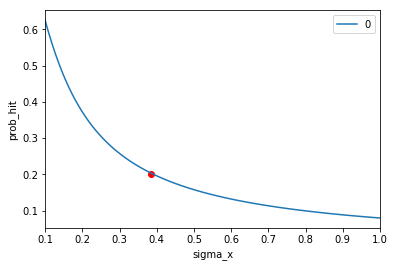

In [4]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem constraints
r_b = 0.1
r_t = 1
mean_x = 0.05 * r_t

# Iterate over many possible sigma_y
results = {}
for sigma_x in np.linspace(0.1, 1, 100):
    prob_hit = norm.cdf(r_b, loc=mean_x, scale=sigma_x) - \
               norm.cdf(-r_b, loc=mean_x, scale=sigma_x)
    results[sigma_x] = prob_hit

# Save the results to a DataFrame and plot them
df = pd.DataFrame.from_dict(results, orient="index")
f = df.plot();
f.set_ylabel("prob_hit")
f.set_xlabel("sigma_x");
plt.scatter(0.385, 0.2, c = 'r');

# Calculate sigma_y based on sigma_x
print('Sigma_y = {}'.format(round(0.385/0.75,3)))

Based on the above figure, I'll select sigma_x equal to 0.385, since it is the point on the line where prob_hit is 0.2. To find sigma_y, we can introduce the constraint from earlier that:

**sigma_x = (0.75)(sigma_y)**

Which makes sigma_y equal to 0.513 (0.385 divided by 0.75), which means that we now have all the required parameters for each Gaussian distribution:

**X ~ N(0.05, 0.385)**
**Y ~ N(0.05, 0.513)**

### Monte Carlo Simulation
Monte Carlo methods use repeated random simulation (sampling) of a distribution to achieve an approximate result. In layman's terms, we're going to randomly pull numbers from each Gaussian distribution, score them based on whether they hit the bullseye or target, repeat this process many times, and then we'll look at the average of the results.

The following code will implement a Monte Carlo solution using 10 million histories (note that using numpy arrays would have been *faster* than the for loop, but I feel that putting the code in this form is *clearer*). It will print out the mean score per dart throw across all 10 million histories.

In [5]:
import random
import numpy as np

# User-defined parameters
n_hist = 1000000
# Radius of the target and bullseye
r_t = 1
r_b = 0.1
# Parameters of the random distributions
mean_x = 0.05
mean_y = 0.05
sigma_x = 0.385
sigma_y = 0.513
# Score for hitting the bullseye, target, and nothing
b_score = 2
t_score = 1
n_score = 0

# Monte Carlo loop
total_score = 0
for n in range(0,n_hist):
    x = random.normalvariate(mean_x, sigma_x)
    y = random.normalvariate(mean_y, sigma_y)
    check = np.sqrt(x**2 + y**2)
    # If it hits the bullseye
    if check < r_b:
        total_score += b_score
    # If it hits the target but not the bullseye
    elif check < r_t:
        total_score += t_score
    # If it hits neither the target nor bullseye
    else:
        total_score += n_score
        
# Find the mean of the Monte Carlo simulation
hist_mean = total_score / n_hist
print('Expected score per dart throw: {}'.format(hist_mean))

Expected score per dart throw: 0.932395


The average score per dart throw is ~0.93, which is higher than the results from Situation 1 and 2, which were ~0.8. The reason is that we assumed that the dart thrower is more experienced and has a better chance to hit the bullseye compared to Situation 1 and 2, where the dart throwing was entirely random (uniform distribution).